In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os.path import isdir, join
from pathlib import Path

import numpy as np
import pandas as pd
import random as rn
import os

from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
# reproducibility

def all_seed(seed_num):
    np.random.seed(seed_num)
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED']=str(seed_num)
    tf.random.set_seed(seed_num)

seed_num = 42
all_seed(seed_num)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Speech_classification/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Speech_classification/test.csv')

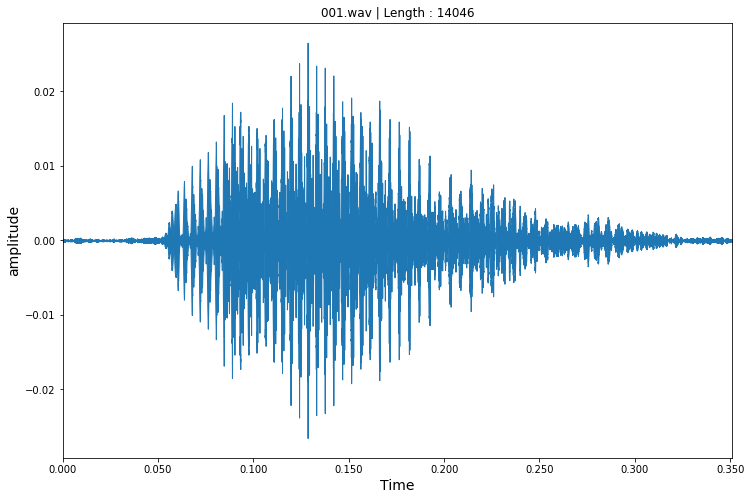

In [ ]:
a_filename = '/content/drive/MyDrive/Speech_classification/dataset/train/001.wav'
# sample_rate, samples = wavfile.read(a_filename)
samples, sample_rate = librosa.load(a_filename)

plt.figure(figsize=(12, 8))
plt.xlabel('time', fontsize = 14)
plt.ylabel('amplitude', fontsize = 14)
plt.title('001.wav | Length : ' + str(len(samples)))
# plt.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)
librosa.display.waveplot(samples, sr=40000)
plt.show()

In [ ]:
print(sample_rate)
print(np.array(samples, dtype='float64'))

22050
[0.00013066 0.00016804 0.00014106 ... 0.00017342 0.00017514 0.        ]


In [ ]:
samples = np.array(samples, dtype='float64')

samples = librosa.resample(samples, sample_rate, 20000)
ipd.Audio(samples, rate=20000)

In [ ]:
def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('001.wav spectrogram | Length : ' + str(len(samples)))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

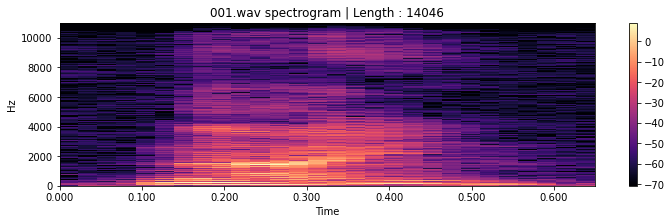

In [ ]:
samples, sample_rate = librosa.load(a_filename)
create_spectrogram(samples, sample_rate)

In [ ]:
train.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


In [ ]:
train['label'].unique()

array([9, 0, 1, 8, 7, 4, 5, 2, 6, 3])

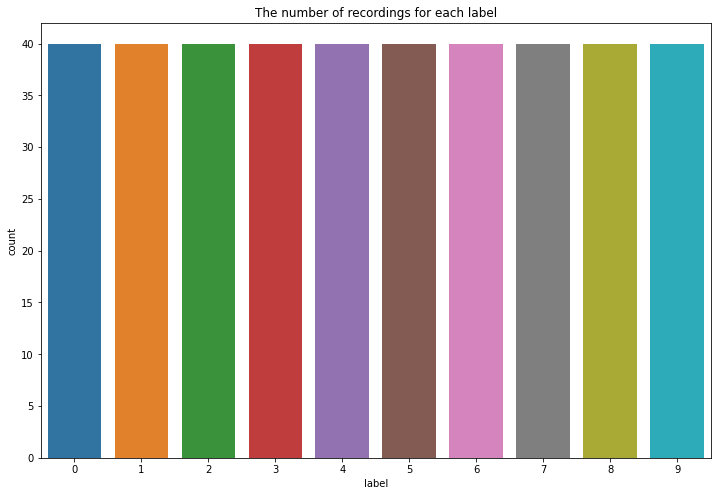

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(train['label'])
plt.title("The number of recordings for each label")
plt.show()

In [ ]:
file_name = train['file_name']

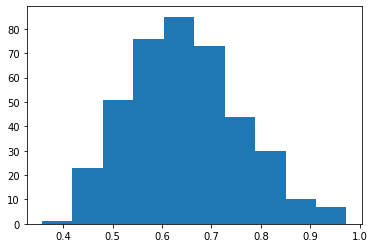

In [ ]:
train_path = '/content/drive/MyDrive/Speech_classification/dataset/train/'
duration_of_recordings=[]
for f in file_name:
    sample_rate, samples = wavfile.read(train_path + f)
    duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))
plt.show()

In [ ]:
all_shape = []
for f in file_name:
  data, sample_rate = librosa.load(train_path + f, sr=20000)
  all_shape.append(data.shape)

In [ ]:
print(all_shape[:5])
print("Max :", np.max(all_shape, axis = 0))
print("Min :", np.min(all_shape, axis = 0))

[(12740,), (13126,), (12910,), (9753,), (17572,)]
Max : [19466]
Min : [7139]


In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [ ]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
labels = train['label']
x, y = [], []
for f, label in zip(file_name, labels):
    feature = get_features(train_path + f)
    for ele in feature:
        x.append(ele)
        y.append(label)

In [ ]:
# all_wave = []
# for f in file_name:
#     samples, sample_rate = librosa.load(train_path + f, sr = 40000)
#     samples = librosa.resample(samples, sample_rate, 20000)
#     if(len(samples)== 20000) : 
#       all_wave.append(samples)
#     else:
#       padding = np.zeros(20000 - len(samples))
#       pad_samples = np.concatenate((samples, padding), axis = 0)
#       all_wave.append(pad_samples)

# X = np.array(all_wave).reshape(-1,20000,1)
# y = train['label']
# print(np.shape(X))
# print(X[0])

In [ ]:
X = x.copy()
Y = y.copy()

In [ ]:
# X = np.expand_dims(X, axis=2)
X = np.array(X)
Y = np.array(Y)

print("Shape of X:", np.shape(X))
print("Shape of Y:", np.shape(Y))

Shape of X: (1200, 162)
Shape of Y: (1200,)


In [ ]:
!pip install flaml
!pip install catboost

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold
from sklearn import metrics

from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from collections import Counter
from flaml import AutoML

In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingCVClassifier

In [ ]:
MODEL_TIME_BUDGET = 60*10
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["lgbm"]

auto_lgbm = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_lgbm.fit(X, Y, **params)

In [ ]:
MODEL_LIST = ["catboost"]

auto_cat = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_cat.fit(X, Y, **params)

In [ ]:
MODEL_LIST = ["xgboost"]

auto_xgb = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_xgb.fit(X, Y, **params)

In [ ]:
MODEL_LIST = ["rf"]

auto_rf = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_rf.fit(X, Y, **params)

In [ ]:
MODEL_LIST = ["extra_tree"]

auto_ext = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_ext.fit(X, Y, **params)

In [ ]:
lightgbm = auto_lgbm.model.estimator
xgboost = auto_xgb.model.estimator
catboost = auto_cat.model.estimator
randomforest = auto_rf.model.estimator
extratree =  auto_ext.model.estimator

In [ ]:
def get_features_test(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # # data with noise
    # noise_data = noise(data)
    # res2 = extract_features(noise_data)
    # result = np.vstack((result, res2)) # stacking vertically
    
    # # data with stretching and pitching
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch)
    # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
test_path = '/content/drive/MyDrive/Speech_classification/dataset/test/'
test_file_name = test['file_name']
x_test = []
for f in test_file_name:
    feature = get_features_test(test_path + f)
    x_test.append(feature)

In [ ]:
x_test = np.array(x_test)
x_test.shape

(200, 162)

In [ ]:
def mode(list):
    count = 0
    mode = 0;
    for x in list: 
        if list.count(x) > count:
            count = list.count(x)
            mode = x

    return mode

prediction = []
for i in range(0, len(x_test)):
    prediction.append(mode([auto_lgbm.predict(x_test)[i], auto_xgb.predict(x_test)[i], auto_cat.predict(x_test)[i], auto_rf.predict(x_test)[i], auto_ext.predict(x_test)[i]]))

In [ ]:
print(prediction)

[0, 9, 3, 3, 2, 9, 9, 9, 3, 5, 3, 1, 5, 2, 9, 2, 8, 7, 7, 1, 3, 1, 0, 8, 2, 0, 8, 7, 3, 8, 6, 4, 3, 0, 9, 0, 0, 8, 1, 1, 0, 2, 1, 0, 4, 7, 4, 5, 7, 0, 4, 2, 1, 9, 9, 4, 9, 3, 6, 3, 6, 0, 6, 5, 7, 4, 2, 1, 2, 7, 8, 0, 0, 4, 1, 5, 9, 9, 7, 7, 1, 5, 7, 5, 5, 9, 9, 0, 6, 6, 6, 9, 7, 9, 6, 8, 2, 1, 6, 1, 7, 0, 0, 8, 7, 3, 5, 8, 9, 9, 7, 9, 9, 9, 2, 7, 2, 4, 0, 4, 8, 0, 9, 9, 7, 6, 3, 4, 5, 8, 6, 3, 3, 8, 5, 8, 6, 6, 2, 6, 9, 4, 3, 4, 5, 5, 1, 8, 1, 3, 2, 5, 4, 6, 3, 1, 9, 9, 5, 7, 6, 8, 1, 1, 2, 0, 6, 0, 5, 7, 4, 9, 4, 8, 4, 8, 4, 2, 8, 5, 5, 0, 6, 2, 8, 7, 8, 5, 5, 3, 9, 3, 0, 4, 2, 6, 0, 3, 8, 8]


In [ ]:
np.shape(prediction)

(200,)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Speech_classification/sample_submission.csv')

submission['label'] = prediction
submission.head()

,file_name,label
0,003.wav,0
1,008.wav,9
2,010.wav,3
3,015.wav,3
4,024.wav,2


In [ ]:
submission.to_csv('/content/drive/MyDrive/Speech_classification/automl.csv', index=False) 